In [1]:
#@title License
# Copyright 2022 The Pix2Seq Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## Pix2seq: A Language Modeling Framework for Object Detection
<a href="https://colab.research.google.com/github/google-research/pix2seq/blob/master/colabs/pix2seq_finetuning_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This colab presents a demo for object detection fine-tuning with Pix2seq. The table below provides a summary and model location for pretrained models on Objects365 dataset, which can be used as initializations for fine-tuning.

Backbone       | Total params (M) | Image size | Google cloud storage location
-------------: | ---------------: | ---------: | -----------:
ResNet-50      | 36.6             | 640x640    | [gs://pix2seq/obj365_pretrain/resnet_640x640_b256_s400k](https://console.cloud.google.com/storage/browser/pix2seq/obj365_pretrain/resnet_640x640_b256_s400k)
ResNet-50 (C4) | 84.7             | 640x640    | [gs://pix2seq/obj365_pretrain/resnetc_640x640_b256_s400k](https://console.cloud.google.com/storage/browser/pix2seq/obj365_pretrain/resnetc_640x640_b256_s400k)
ViT-L          | 115.2            | 640x640    | [gs://pix2seq/obj365_pretrain/vit_b_640x640_b256_s400k](https://console.cloud.google.com/storage/browser/pix2seq/obj365_pretrain/vit_b_640x640_b256_s400k)
ViT-B          | 341.2            | 640x640    | [gs://pix2seq/obj365_pretrain/vit_l_640x640_b256_s400k](https://console.cloud.google.com/storage/browser/pix2seq/obj365_pretrain/vit_l_640x640_b256_s400k)


In [2]:
# pip installs.
#!pip install ml_collections
#!pip install tensorflow-addons
#!git clone https://github.com/google/pix2seq.git

import os, sys

sys.path.append(os.getcwd())
root_dir = os.getcwd()
sys.path.insert(1, 'pix2seq')

In [3]:
# Imports.
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import requests
import json

import ml_collections
import utils
from data.dataset import Dataset
from models import model as model_lib
from models import ar_model
from tasks import task as task_lib
from tasks import object_detection

In [4]:
# Define a Dataset class to use for finetuning.
class VocDataset(Dataset):

  def extract(self, example, training):
    """Extracts needed features & annotations into a flat dictionary.

    Note: be consisous about 0 in label, which should probably reserved for
       special use (such as padding).

    Args:
      example: `dict` of raw features.
      training: `bool` of training vs eval mode.

    Returns:
      example: `dict` of relevant features and labels
    """
    # These features are needed by the object detection task.
    features = {
        'image': tf.image.convert_image_dtype(example['image'], tf.float32),
        'image/id': 0, # dummy int.
    }

    # The following labels are needed by the object detection task.
    label = example['objects']['label'] + 1  # 0 is reserved for padding.
    bbox = example['objects']['bbox']

    # Use tf.numpy_function to get features not easily computed in tf.
    def get_area(bboxes):
      return np.asarray([
          (b[2] - b[0]) * (b[3] - b[1]) for b in bboxes], dtype=np.int32)

    areas = tf.numpy_function(get_area, (bbox,), (tf.int32,))
    areas = tf.reshape(areas, [tf.shape(label)[0]])

    labels = {
        'label': label,
        'bbox': bbox,
        'area': areas,
        'is_crowd': tf.zeros_like(label, tf.bool),
    }
    return features, labels

In [5]:
# Load config for the pretrained model.
#pretrained_model_dir = 'gs://pix2seq/obj365_pretrain/resnet_640x640_b256_s400k/'
pretrained_model_dir = './obj365_pretrain/resnet_640x640_b256_s400k/'
with tf.io.gfile.GFile(os.path.join(pretrained_model_dir, 'config.json'), 'r') as f:
  config = ml_collections.ConfigDict(json.loads(f.read()))
print(config)

dataset:
  base_dir: ''
  batch_duplicates: 1
  cache_dataset: false
  coco_annotations_dir: ''
  eval_split: validation
  label_shift: 200
  name: obj365v2
  train_split: train
eval:
  batch_size: 8
  checkpoint_dir: null
  steps: null
  tag: eval
model:
  coord_vocab_shift: 1000
  dec_proj_mode: mlp
  decoder_output_bias: true
  dim_att: 256
  dim_att_dec: 256
  dim_mlp: 1024
  dim_mlp_dec: 1024
  drop_att: 0.0
  drop_path: 0.1
  drop_units: 0.1
  image_size: 640
  max_seq_len: 512
  num_decoder_layers: 6
  num_encoder_layers: 6
  num_heads: 8
  num_heads_dec: 8
  patch_size: 16
  pos_encoding: sin_cos
  pos_encoding_dec: learned
  pretrained_ckpt: null
  resnet_depth: 50
  resnet_sk_ratio: 0.0
  resnet_variant: standard
  resnet_width_multiplier: 1
  shared_decoder_embedding: true
  text_vocab_shift: 3000
  use_cls_token: false
  vocab_size: 3000
optimization:
  beta1: 0.9
  beta2: 0.95
  end_lr_factor: 0.01
  eps: 1.0e-08
  global_clipnorm: -1
  learning_rate: 0.001
  learning_rate

In [6]:

# Update config for finetuning (some configs were missing at initial pretraining time).
config.dataset.tfds_name = 'voc'
config.dataset.batch_duplicates = 1
config.dataset.coco_annotations_dir = None
config.task.name == 'object_detection'
config.task.vocab_id = 10  # object_detection task vocab id.
config.task.weight = 1.
config.task.max_instances_per_image_test = 10
config.tasks = [config.task]
config.train.batch_size = 8
config.model.name = 'encoder_ar_decoder'  # name of model and trainer in registries.
config.model.pretrained_ckpt = pretrained_model_dir
config.optimization.learning_rate = 1e-4
config.optimization.warmup_steps = 10

# Use a smaller image_size to speed up finetuning here.
# You can use any image_size of choice.
config.model.image_size = 320
config.task.image_size = 320

In [7]:
# Perform training for 1000 steps. This takes about ~20 minutes on a regular Colab GPU.
train_steps = 1000
use_tpu = False  # Set this accordingly.
steps_per_loop = 10
tf.config.run_functions_eagerly(False)

strategy = utils.build_strategy(use_tpu=use_tpu, master='')

# The following snippets are mostly copied and simplified from run.py.
with strategy.scope():
  # Get dataset.
  dataset = VocDataset(config)

  # Get task.
  task = task_lib.TaskRegistry.lookup(config.task.name)(config)
  tasks = [task]

  # Create tf.data.Dataset.
  ds = dataset.pipeline(
      process_single_example=task.preprocess_single,
      global_batch_size=config.train.batch_size,
      training=True)
  datasets = [ds]
  
  # Setup training elements.
  trainer = model_lib.TrainerRegistry.lookup(config.model.name)(
      config, model_dir='model_dir',
      num_train_examples=dataset.num_train_examples, train_steps=train_steps)
  data_iterators = [iter(dataset) for dataset in datasets]

  @tf.function
  def train_multiple_steps(data_iterators, tasks):
    train_step = lambda xs, ts=tasks: trainer.train_step(xs, ts, strategy)
    for _ in tf.range(steps_per_loop):  # using tf.range prevents unroll.
      with tf.name_scope(''):  # prevent `while_` prefix for variable names.
        strategy.run(train_step, ([next(it) for it in data_iterators],))

  global_step = trainer.optimizer.iterations
  cur_step = global_step.numpy()
  while cur_step < train_steps:
    train_multiple_steps(data_iterators, tasks)
    cur_step = global_step.numpy()
    print(f"Done training {cur_step} steps.")

2022-05-16 11:07:08.217492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-16 11:07:08.404352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-16 11:07:08.404778: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-16 11:07:08.410662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-16 11:07:08.411193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not op

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/4952 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteDAR6QH/voc-test.tfrecord*...:   0%|          | 0/…

Generating train examples...:   0%|          | 0/2501 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteDAR6QH/voc-train.tfrecord*...:   0%|          | 0…

Generating validation examples...:   0%|          | 0/2510 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteDAR6QH/voc-validation.tfrecord*...:   0%|        …

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost

In [8]:
# Run one step of inference (on the training set).

# Set category names in task for visualization.
# The category names for COCO are picked up from the coco annotation files. For
# other datasets, they can be added manually in the code. If they are missing,
# the visualization will not contain category names for predicted boxes, but
# no other things will be impacted.
category_names = [
    'Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle', 'Bus', 'Car', 'Cat',
    'Chair', 'Cow', 'Dining table', 'Dog', 'Horse', 'Motorbike', 'People',
    'Potted plant', 'Sheep', 'Sofa', 'Train', 'TV/monitor']
task._category_names = {
    i + 1 : {'name': name} for i, name in enumerate(category_names)}

def single_step(examples):
  preprocessed_outputs = task.preprocess_batched(examples, training=False)
  infer_outputs = task.infer(trainer.model, preprocessed_outputs)
  return task.postprocess_tpu(*infer_outputs)

with strategy.scope():
  @tf.function
  def run_single_step(iterator):
    examples = next(iterator)
    outputs = strategy.run(single_step, (examples,))
    if outputs is not None:
      outputs = [strategy.gather(t, axis=0) for t in outputs]
    return outputs

  iterator = iter(ds)
  per_step_outputs = run_single_step(iterator)
  vis = task.postprocess_cpu(
      per_step_outputs,
      train_step=100,
      eval_step=0,
      ret_results=True)

2022-05-16 11:52:50.723934: W tensorflow/core/grappler/optimizers/data/slack.cc:103] Could not find a final `prefetch` in the input pipeline to which to introduce slack.


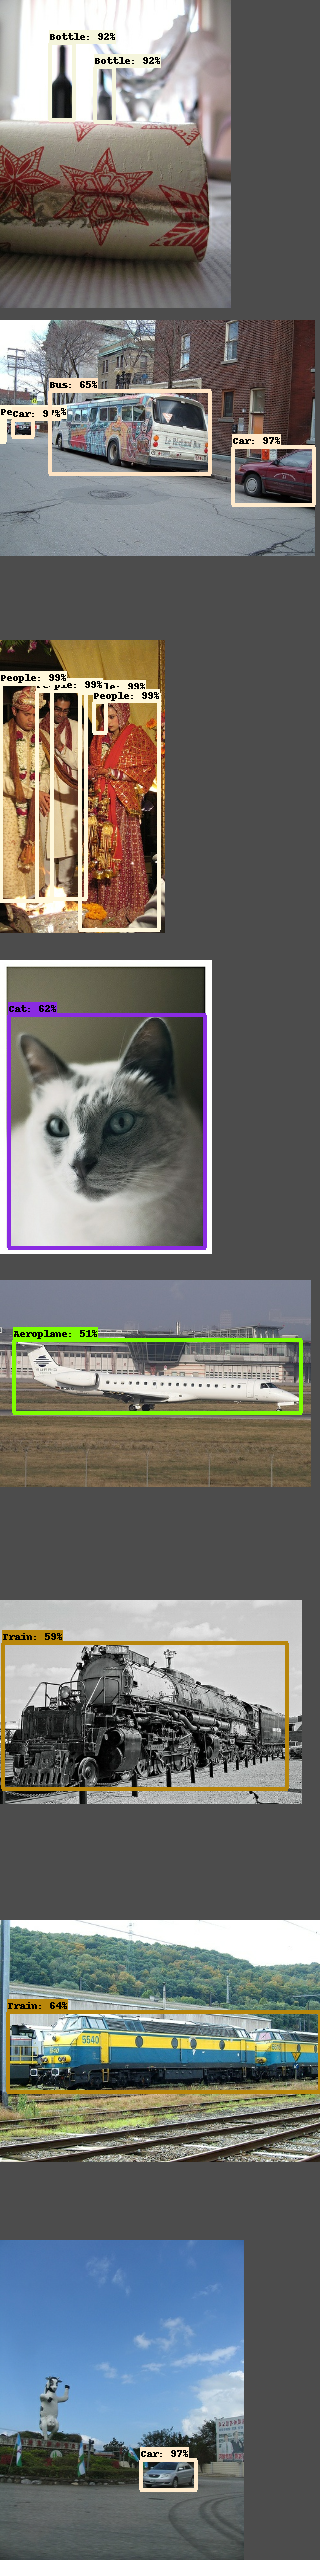

In [9]:
# Visualization.
im = tf.concat([vis['pred'][i] for i in range(config.train.batch_size)], 0)
Image.fromarray(np.uint8(im.numpy() * 255))